# Insights from failed orders

## Introduction

Gett, a technology platform focused on transportation management, has an application that allows customers to order taxi and drivers to accept their rides.

In this project, I would like to investigate some matching metrics for orders that were not completed successfully (the curstomer did not end up getting a car).

The analysis consists of the following components:
- Building up a distribution of orders according to reasons for failure: cancellations before and after assignment, and the reason for order rejection.
- Plotting the distribution of failed orders by hour, and check is there a trend that certain hours have an abnormally high proportion of one category than another, and how could the trend be explained.
- Plotting the average time to cancellation with and without drive to check if there are any outliers in the data. If there are, remove them and draw further conclusions from the plot
- Plotting the distribution of average ETA by hours and explain the trend observed in the plot.

## Data Description
Two datasets are provided: data_orders and data_offers.
data_orders contains the following columns:
-  ordr_datetime
- orgin_longtitude
- origin_latitude
- m_order_eta	
- order_gk	
- order_status_key
    - 4 - cancelled by client
    - 9 - cancelled by system
- is_driver_assigned_key	
- cancellations_time_in_seconds

data_offers contains the following columns:
- order_gk
- offer_id

## Preliminary data examination and manipulation

In [2]:
import numpy as np
import pandas as pd

Start off by importing datasets, and investigate them one by one

In [3]:
offers = pd.read_csv('C:/Users/weila/Desktop/datasets_Gett/datasets/data_offers.csv')
orders = pd.read_csv('C:/Users/weila/Desktop/datasets_Gett/datasets/data_orders.csv')

In [4]:
print(orders.shape)

(10716, 8)


In [5]:
# Investigating the proportion of missing values
orders.isnull().sum()/orders.shape[0]

order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
order_status_key                 0.000000
is_driver_assigned_key           0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

In [6]:
# Inspect data formats and missing values in the dataset
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [7]:
# Convert order_datetime from string to datetime format for easier manipulation
orders.order_datetime = pd.to_datetime(orders.order_datetime)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10716 non-null  datetime64[ns]
 1   origin_longitude               10716 non-null  float64       
 2   origin_latitude                10716 non-null  float64       
 3   m_order_eta                    2814 non-null   float64       
 4   order_gk                       10716 non-null  int64         
 5   order_status_key               10716 non-null  int64         
 6   is_driver_assigned_key         10716 non-null  int64         
 7   cancellations_time_in_seconds  7307 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 669.9 KB


I will examine offers dataset next following the same procedure.

In [8]:
print(offers.shape)

(334363, 2)


In [9]:
offers.isnull().sum()

order_gk    0
offer_id    0
dtype: int64

In [10]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [11]:
all_columns = pd.Series(list(offers)+list(orders))
all_columns[all_columns.duplicated()]

6    order_gk
dtype: object

Merge two datasets on the 'order_gk' column for easier manipulation and analysis.

In [12]:
df = pd.merge(orders, offers, how = 'inner', on = 'order_gk')
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,2023-08-14 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,2023-08-14 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


In order to better contextualize the data, I will change the binary variables 'is_driver_assigned_key' and 'order_status_key' to strings with actual meaning.

'is_driver_assigned_key': 
                
               1->Yes

               0->No
               
'order_status_key': 
              
              4->Client_cancelled

              9->System_rejected 

In [13]:
df['is_driver_assigned_key'] = np.where(df['is_driver_assigned_key']==1, 'Yes', 'No')
df['order_status_key'] = np.where(df['order_status_key']==4, 'Client_cancelled', 'System_rejected')

In [14]:
df.rename(columns = {'order_datetime':'order_time','order_longtitude':'longtitude',
                    'origin_latitude':'latitude','m_order_eta':'ETA','order_gk':'order_id',
                    'order_status_key':'order_status','is_driver_assigned_key':'is_driver_assigned',
                    'cancellations_time_in_seconds':'cancellation_time'}, inplace=True)

In [15]:
df.head()

,order_time,origin_longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellation_time,offer_id
0,2023-08-14 18:08:07,-0.978916,51.456173,60.0,3000583041974,Client_cancelled,Yes,198.0,300050983403
1,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986179
2,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986174
3,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986180
4,2023-08-14 12:07:50,-0.969520,51.455544,477.0,3000582891479,Client_cancelled,Yes,46.0,300050976275


## Explanatory data analysis

### Part 1

Building up a distribution of orders according to reasons for failure: cancellations before and after assignment, and the reason for order rejection.

In [34]:
cancellations = df.groupby(['is_driver_assigned', 'order_status']).order_id.size().reset_index()
cancellations['total'] = cancellations.groupby('is_driver_assigned')['order_id'].transform('sum')
cancellations['percentage'] = cancellations.order_id/cancellations.total
cancellations

,is_driver_assigned,order_status,order_id,total,percentage
0,No,Client_cancelled,13435,22904,0.586579
1,No,System_rejected,9469,22904,0.413421
2,Yes,Client_cancelled,8360,8364,0.999522
3,Yes,System_rejected,4,8364,0.000478


<Axes: title={'center': 'Distribution of cancellations according to reasons for failure'}, ylabel='Number of cancellations'>

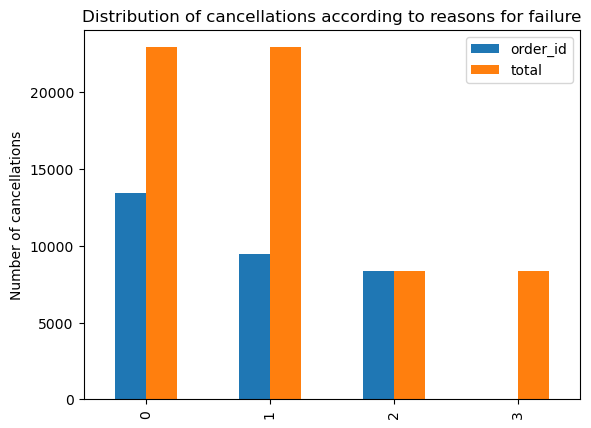

In [41]:
cancellations[['order_id','total']].plot(kind='bar', legend=True, subplots=False, ylabel='Number of cancellations', title = 'Distribution of cancellations according to reasons for failure')

   It is observed that the majority of cancellations are made before drivers are assigned. In this scenario, 59% of cancellations are due to 'client cancel' and the rest are caused by 'system rejection'. A possible explanation would be that clients wait to long before getting assigned a driver.
    
   However, after a driver is assigned, almost all the cancellations(over 99%) are caused by 'client cancel'.

### Part 2

Plotting the distribution of failed orders by hour, and check is there a trend that certain hours have an abnormally high proportion of one category than another, and how could the trend be explained.

In [42]:
df['order_hour'] = df['order_time'].dt.hour
df.head()

,order_time,origin_longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellation_time,offer_id,order_hour
0,2023-08-14 18:08:07,-0.978916,51.456173,60.0,3000583041974,Client_cancelled,Yes,198.0,300050983403,18
1,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986179,20
2,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986174,20
3,2023-08-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_cancelled,No,128.0,300050986180,20
4,2023-08-14 12:07:50,-0.969520,51.455544,477.0,3000582891479,Client_cancelled,Yes,46.0,300050976275,12


<Axes: xlabel='order_hour', ylabel='Number of cancellations'>

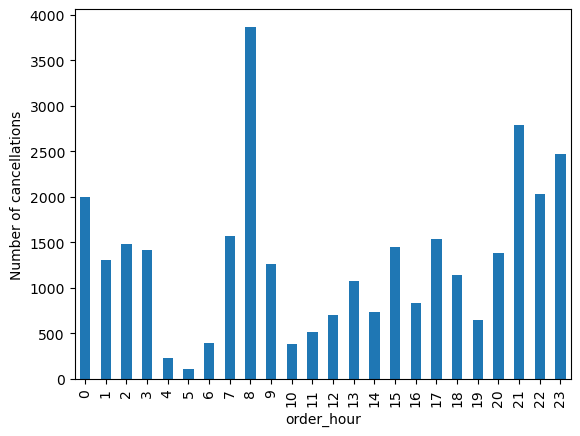

In [43]:
df.groupby('order_hour')['order_id'].size().plot(kind='bar', ylabel='Number of cancellations')

It is observed from the above graph that the largest number of cancellations occur at 8, followed by 21 and 23.

To deeper our understanding of cancellatios by category, I will breakdown this data by hour and by category.

In [44]:
q2 = df.groupby(['order_hour','is_driver_assigned','order_status'])['order_id'].size().reset_index()
q2

,order_hour,is_driver_assigned,order_status,order_id
0,0,No,Client_cancelled,957
1,0,No,System_rejected,706
2,0,Yes,Client_cancelled,326
3,0,Yes,System_rejected,4
4,1,No,Client_cancelled,633
...,...,...,...,...
68,22,No,System_rejected,660
69,22,Yes,Client_cancelled,415
70,23,No,Client_cancelled,1144
71,23,No,System_rejected,883


<Axes: xlabel='order_hour', ylabel='Number of cancellations'>

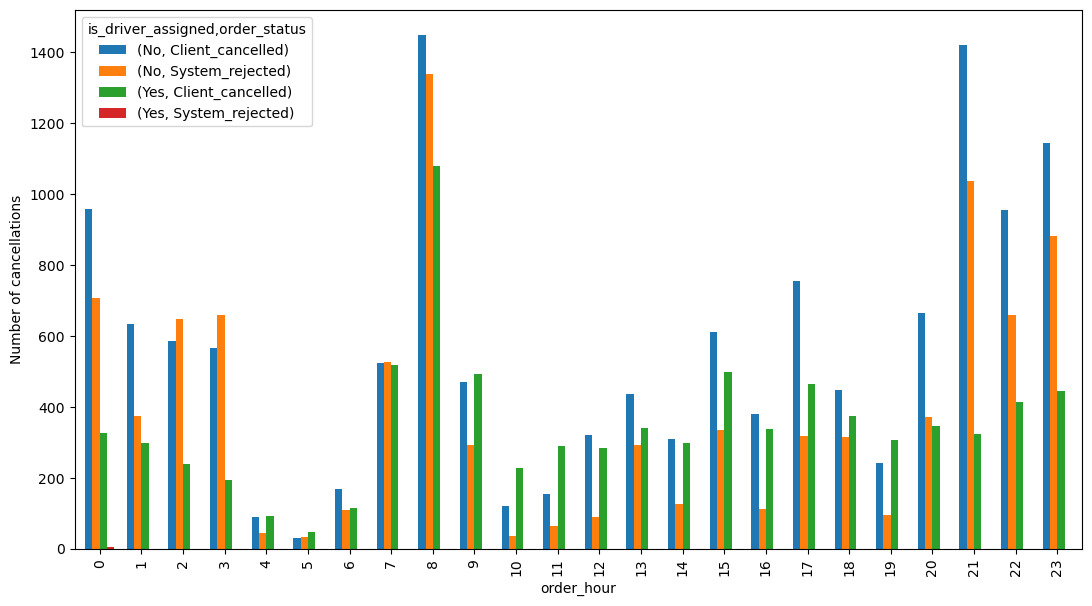

In [51]:
q2_pivot = q2.pivot(index='order_hour',columns=['is_driver_assigned','order_status'],values='order_id')
q2_pivot.plot(kind='bar', figsize=(13,7), width=0.7, ylabel='Number of cancellations')

From the breakdown of cancellations by category, it is observed that high cancellations across all sections contribute to the largest number of cancelled orders at 8. This could be explained by massive demands for transportation to work in the morning. Due to the requirement of timely arrival, customers will not wait for too long, resulting in high volume of cancelled orders.

### Part 3

Plotting the average time to cancellation with and without drive to check if there are any outliers in the data. If there are, remove them and draw further conclusions from the plot

In [54]:
q3 = df.groupby(['order_hour','is_driver_assigned'], as_index=False)['cancellation_time'].mean()
q3

,order_hour,is_driver_assigned,cancellation_time
0,0,No,115.126437
1,0,Yes,276.082822
2,1,No,100.593997
3,1,Yes,296.312081
4,2,No,121.305461
5,2,Yes,301.466667
6,3,No,129.182301
7,3,Yes,368.682051
8,4,No,100.733333
9,4,Yes,245.250000


<Axes: xlabel='order_hour', ylabel='Average cancellation time'>

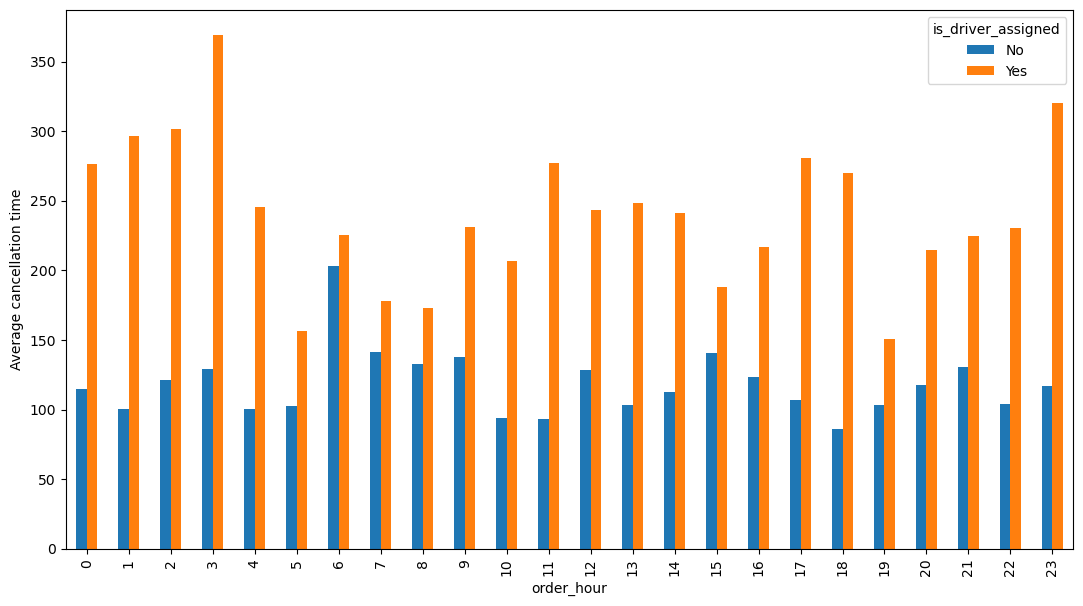

In [59]:
q3_pivot = q3.pivot(index='order_hour', columns='is_driver_assigned',values='cancellation_time')

q3_pivot.plot(kind='bar',figsize=(13,7),ylabel='Average cancellation time')

No exceptional outlier is detected in this case.

The average time to cancel is longer for customers who have been assigned drivers than those without. This conclusion seems logical because customers are more likely to wait patiently when a driver is actually assigned.

### Part 4

Plotting the distribution of average ETA by hours and explain the trend observed in the plot.

<Axes: xlabel='order_hour', ylabel='Average ETA'>

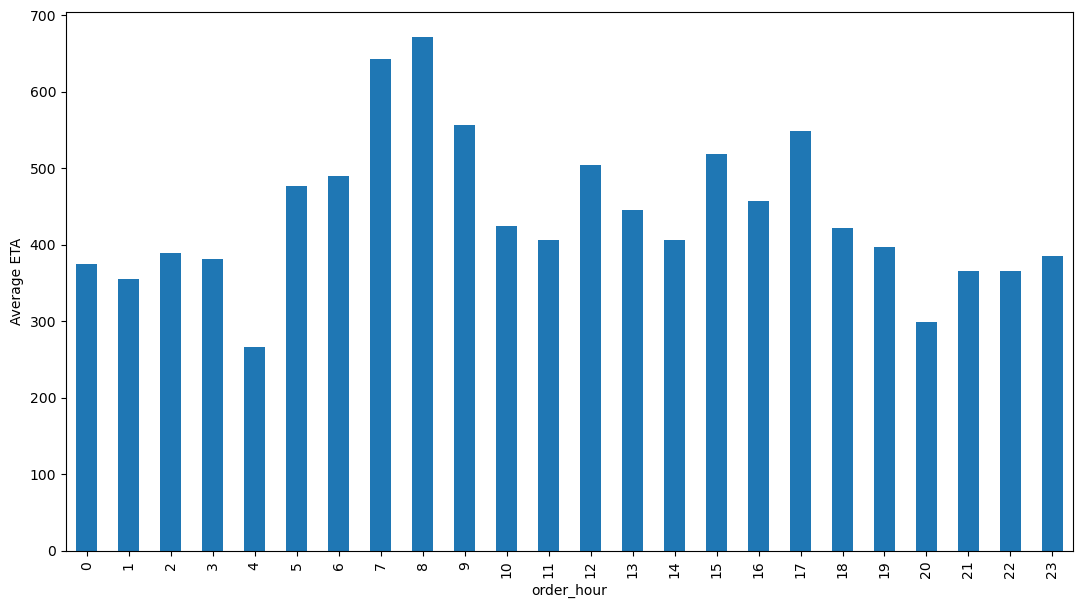

In [61]:
df.groupby('order_hour')['ETA'].mean().plot(kind='bar',figsize=(13,7),ylabel='Average ETA')

This graph matches the previous graph on count of failed orders per hour, which indicates that failed orders is correlated with average waiting time of customers.

## Conclusion

A general overservation from this project is that the majority of cancellations happen before drivers are assigned, indicating that customers have waited too long to be assigned a driver.Incorporating our analysis by hour and cancellation category, we can reach the following recommendations to reduce cancellations:
- Reduce wait time around 8:00 and 17:00, since this time coincides with rush hours when a large volume of transportation is demanded. This could potentially be achieved by offering more incentives to drivers during this time, and improving ordering platform to reduce latency.
- No further context is provided regarding why the system would reject orders. I look forward to investigating further into this matter, as it is also a significant reason for cancellations.